## Common libraries 

In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,  recall_score, precision_score, f1_score,average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.base import clone
from sklearn.decomposition import PCA, TruncatedSVD


from collections import Counter, defaultdict
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time 

## Data Preparation and Encoding

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


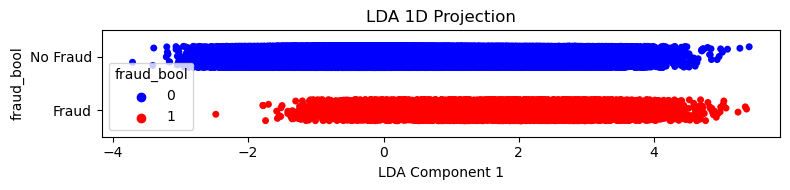

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# Fit LDA
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_train, y_train)


# Plot
plt.figure(figsize=(8, 2))
sns.stripplot(x=X_lda.ravel(), y=y_train, hue=y_train, palette=['blue', 'red'], orient='h', jitter=0.2)
plt.title("LDA 1D Projection")
plt.xlabel("LDA Component 1")
plt.yticks([0, 1], ['No Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

In [2]:

# Load data
df=pd.read_csv('../../data/Base.csv')

# Identify features
target_col = 'fraud_bool'
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numeric_cols = df.select_dtypes(include='number').drop(columns=target_col).columns.tolist()

# One-hot encode categoricals
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Split features/target
X = df_encoded.drop(columns=target_col)
y = df_encoded[target_col]

# Standard Scale the numerical columns 
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


## Naive baseline models

In [26]:
# 1. Baseline Dummy Model: Always predict non-fraud (0)
y_pred_dummy = np.zeros_like(y_test)

# Metrics for Dummy
print("=== Baseline Dummy Model (Always Predicts Non-Fraud) ===")
print(f"Recall:    {recall_score(y_test, y_pred_dummy):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print()

# 2. Logistic Regression on Selected Features
selected_features = ['income', 'customer_age', 'credit_risk_score', 'keep_alive_session'] + \
                    [col for col in X.columns if col.startswith('device_os_')]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_selected, y_train)
y_pred_logreg = logreg.predict(X_test_selected)

# Metrics for Logistic Regression
print("=== Logistic Regression on Selected Features ===")
print(f"Recall:    {recall_score(y_test, y_pred_logreg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_logreg, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_logreg, zero_division=0):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, logreg.predict_proba(X_test_selected)[:,1]):.4f}")

=== Baseline Dummy Model (Always Predicts Non-Fraud) ===
Recall:    0.0000
Precision: 0.0000
F1 Score:  0.0000

=== Logistic Regression on Selected Features ===
Recall:    0.0000
Precision: 0.0000
F1 Score:  0.0000
PR AUC:    0.0590


## Clustering Analysis

In [11]:
 # T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_train)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_train)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X_train)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))


T-SNE took 1.5e+04 s
PCA took 3.2 s
Truncated SVD took 1.7 s


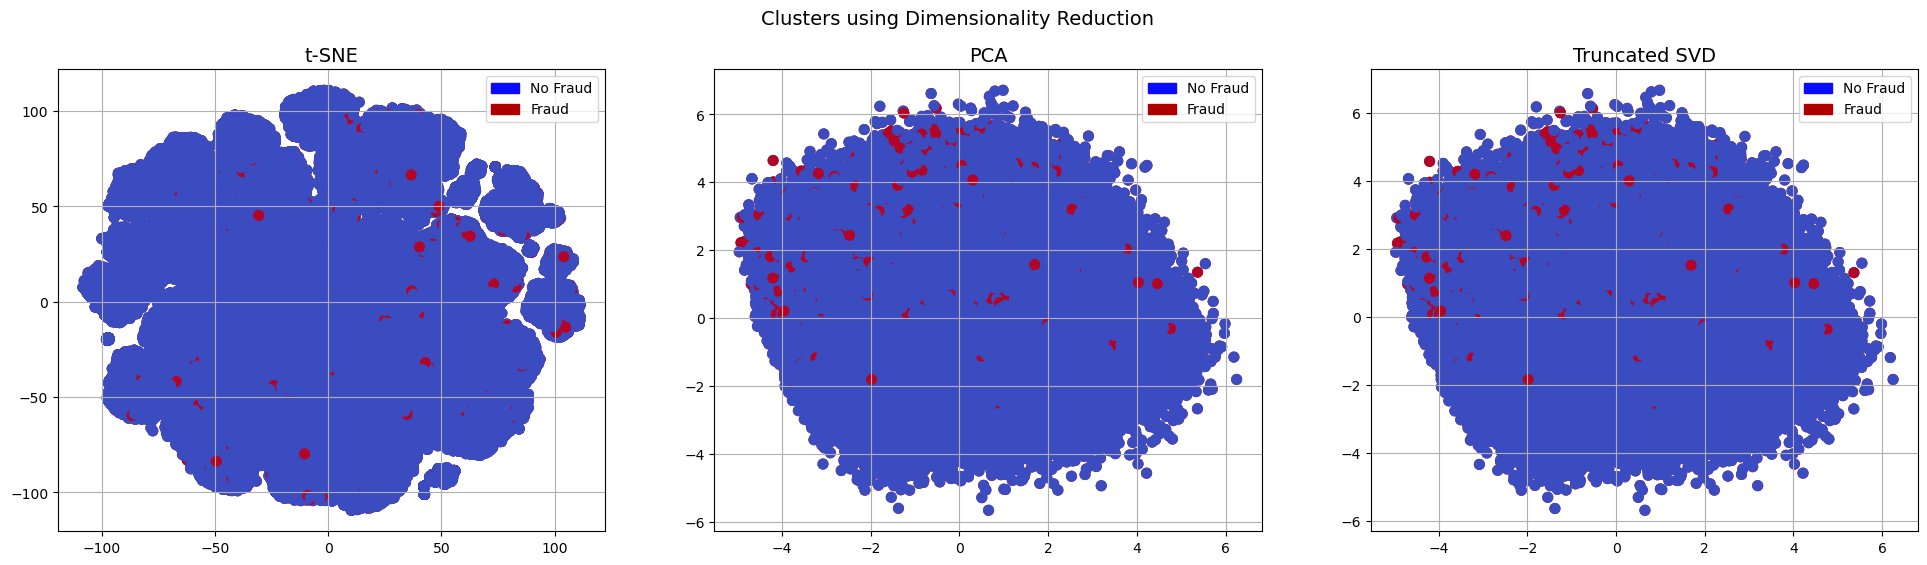

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train== 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_train== 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y_train == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_train == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y_train == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

Checking if LDA is better

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


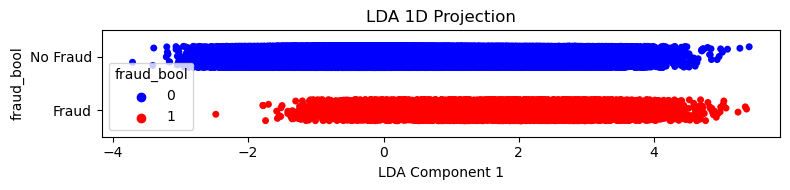

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# Fit LDA
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_train, y_train)


# Plot
plt.figure(figsize=(8, 2))
sns.stripplot(x=X_lda.ravel(), y=y_train, hue=y_train, palette=['blue', 'red'], orient='h', jitter=0.2)
plt.title("LDA 1D Projection")
plt.xlabel("LDA Component 1")
plt.yticks([0, 1], ['No Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

Thus, we observe that neither clustering technique achieves a clear separation between fraud and non-fraud cases.

## Undersampling with 1:1 Ratio and Model selection




In [3]:
folds_under = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X_train, y_train):
    X_fold_train, y_fold_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_fold_val, y_fold_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

    train_df = X_fold_train.copy()
    train_df['y'] = y_fold_train.values

    class_0 = train_df[train_df['y'] == 0]
    class_1 = train_df[train_df['y'] == 1]

    maj_class, min_class = (class_0, class_1) if len(class_0) > len(class_1) else (class_1, class_0)

    maj_class_down = resample(maj_class, replace=False, n_samples=len(min_class), random_state=42)
    balanced_train = pd.concat([maj_class_down, min_class]).sample(frac=1, random_state=42).reset_index(drop=True)

    X_resampled = balanced_train.drop(columns='y')
    y_resampled = balanced_train['y']

    folds_under.append({
        'train': {'X': X_resampled, 'y': y_resampled},
        'val': {'X': X_fold_val.reset_index(drop=True), 'y': y_fold_val.reset_index(drop=True)}
    })


If you have time you can run SVC but it takes long and doesnt give great results 

In [4]:
# Define parameter grids
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "solver": ["liblinear"]}
knears_params = {"n_neighbors": list(range(2, 5))}
#svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf']}
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2, 4)), "min_samples_leaf": list(range(5, 7))}

# Models
models = {
    "Logistic Regression": (LogisticRegression(), log_reg_params),
    "KNN": (KNeighborsClassifier(), knears_params),
    #"SVC": (SVC(), svc_params),
    "Decision Tree": (DecisionTreeClassifier(), tree_params)
}

In [5]:
# For storing best params and scores
results_under = {}
best_params_summary_under = defaultdict(list)

for model_name, (model, param_grid) in models.items():
    print(f"\n====== {model_name} ======\n")
    train_recalls = []
    val_recalls = []
    val_precisions = []
    val_f1s = []
    val_pr_aucs = []
    best_params_per_fold = []

    for i, fold in enumerate(folds_under):
        X_train_fold = fold['train']['X']
        y_train_fold = fold['train']['y']
        X_val_fold = fold['val']['X']
        y_val_fold = fold['val']['y']
        
        grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, scoring="recall")
        grid.fit(X_train_fold, y_train_fold)
        best_model = grid.best_estimator_
        best_params = tuple(sorted(grid.best_params_.items()))

        best_params_per_fold.append(best_params)
        best_params_summary_under[model_name].append(best_params)

        # Predict
        y_train_pred = best_model.predict(X_train_fold)
        y_val_pred = best_model.predict(X_val_fold)
        y_val_prob = best_model.predict_proba(X_val_fold)[:, 1] if hasattr(best_model, "predict_proba") else None

        # Evaluate metrics
        train_recall = recall_score(y_train_fold, y_train_pred)
        val_recall = recall_score(y_val_fold, y_val_pred)
        val_precision = precision_score(y_val_fold, y_val_pred, zero_division=0)
        val_f1 = f1_score(y_val_fold, y_val_pred, zero_division=0)
        val_pr_auc = average_precision_score(y_val_fold, y_val_prob) if y_val_prob is not None else None

        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        val_precisions.append(val_precision)
        val_f1s.append(val_f1)
        if val_pr_auc is not None:
            val_pr_aucs.append(val_pr_auc)

        print(f"Fold {i+1}:")
        print(f"  Best Params:     {dict(best_params)}")
        print(f"  Train Recall:    {train_recall:.4f}")
        print(f"  Val Recall:      {val_recall:.4f}")
        print(f"  Val Precision:   {val_precision:.4f}")
        print(f"  Val F1 Score:    {val_f1:.4f}")
        if val_pr_auc is not None:
            print(f"  Val PR AUC:      {val_pr_auc:.4f}")
        print()

    # Most frequent best params
    most_common_params = Counter(best_params_per_fold).most_common(1)[0][0]

    results_under[model_name] = {
        "model" : model,
        "avg_train_recall": np.mean(train_recalls),
        "avg_val_recall": np.mean(val_recalls),
        "avg_precision": np.mean(val_precisions),
        "avg_f1": np.mean(val_f1s),
        "avg_pr_auc": np.mean(val_pr_aucs) if val_pr_aucs else None,
        "best_params": dict(most_common_params)
    }

# Summary
print("\n===== Summary (Selection by Recall) =====\n")
for model_name, res in results_under.items():
    print(f"{model_name}:")
    print(f"  Avg Train Recall:   {res['avg_train_recall']:.4f}")
    print(f"  Avg Val Recall:     {res['avg_val_recall']:.4f}")
    print(f"  Avg Val Precision:  {res['avg_precision']:.4f}")
    print(f"  Avg Val F1-Score:   {res['avg_f1']:.4f}")
    if res["avg_pr_auc"] is not None:
        print(f"  Avg Val PR AUC:     {res['avg_pr_auc']:.4f}")
    print(f"  Selected Best Params: {res['best_params']}\n")


====== Logistic Regression ======

Fold 1:
  Best Params:     {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
  Train Recall:    0.8020
  Val Recall:      0.7823
  Val Precision:   0.0337
  Val F1 Score:    0.0646
  Val PR AUC:      0.1144

Fold 2:
  Best Params:     {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
  Train Recall:    0.8004
  Val Recall:      0.7948
  Val Precision:   0.0343
  Val F1 Score:    0.0658
  Val PR AUC:      0.1247

Fold 3:
  Best Params:     {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
  Train Recall:    0.7973
  Val Recall:      0.8091
  Val Precision:   0.0351
  Val F1 Score:    0.0672
  Val PR AUC:      0.1196

Fold 4:
  Best Params:     {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
  Train Recall:    0.7982
  Val Recall:      0.7921
  Val Precision:   0.0345
  Val F1 Score:    0.0662
  Val PR AUC:      0.1179

Fold 5:
  Best Params:     {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
  Train Recall:    0.7964
  Val Recall: 

Now we check our models with the best parameters on the test set 

In [6]:
print("\n===== Best models using undersampling  on X _test; =====\n")

final_scores = {}

for model_name, info in results_under.items():
    model = info["model"]
    best_params = info["best_params"]

    model_clone = clone(model)
    model_clone.set_params(**best_params)

    # Train on full training data
    X_train_all = pd.concat([fold['train']['X'] for fold in folds_under])
    y_train_all = pd.concat([fold['train']['y'] for fold in folds_under])
    model_clone.fit(X_train_all, y_train_all)

    # Predict
    y_pred = model_clone.predict(X_test)
    y_prob = model_clone.predict_proba(X_test)[:, 1] if hasattr(model_clone, "predict_proba") else None

    # Metrics
    final_recall = recall_score(y_test, y_pred)
    final_precision = precision_score(y_test, y_pred, zero_division=0)
    final_f1 = f1_score(y_test, y_pred, zero_division=0)
    final_pr_auc = average_precision_score(y_test, y_prob) if y_prob is not None else None

    final_scores[model_name] = {
        "model": model_clone,
        "recall": final_recall,
        "precision": final_precision,
        "f1": final_f1,
        "pr_auc": final_pr_auc
    }

    print(f"{model_name} results on the test set:")
    print(f"  Recall:    {final_recall:.4f}")
    print(f"  Precision: {final_precision:.4f}")
    print(f"  F1 Score:  {final_f1:.4f}")
    if final_pr_auc is not None:
        print(f"  PR AUC:    {final_pr_auc:.4f}")
    print()


===== Best models using undersampling  on X _test; =====

Logistic Regression results on the test set:
  Recall:    0.7933
  Precision: 0.0399
  F1 Score:  0.0759
  PR AUC:    0.1343

KNN results on the test set:
  Recall:    0.6700
  Precision: 0.0294
  F1 Score:  0.0563
  PR AUC:    0.0278

Decision Tree results on the test set:
  Recall:    0.8626
  Precision: 0.0192
  F1 Score:  0.0376
  PR AUC:    0.0324



Now we check if the combination of models provides better results 

In [12]:
import itertools
 
 
from tqdm import tqdm   
# Coefficients to try
coeffs = [0, 0.25, 0.5, 0.75, 1]

# Prepare
results = []

# Get the models
model_1 = final_scores["Logistic Regression"]["model"]
model_2 = final_scores["KNN"]["model"]
model_3 = final_scores["Decision Tree"]["model"]

# Get model predictions on X_test
proba_1 = model_1.predict_proba(X_test)[:, 1]
proba_2 = model_2.predict_proba(X_test)[:, 1]
proba_3 = model_3.predict_proba(X_test)[:, 1]

# Iterate over all coefficient combinations
for c1, c2, c3 in tqdm(itertools.product(coeffs, repeat=3), total=len(coeffs)**3):  # <--- tqdm here
    if c1 == 0 and c2 == 0 and c3 == 0:
        continue  # Skip the trivial case where all coefficients are 0

    # Combine probabilities
    combined_proba = c1 * proba_1 + c2 * proba_2 + c3 * proba_3

    # Normalize to [0,1] 
    combined_proba = combined_proba / combined_proba.max()

    # Find the best threshold based on F1
    best_f1 = 0
    best_thresh = 0.5

    for t in np.arange(0, 1.01, 0.01):  # From 0.0 to 1.0 with step 0.1
        preds = (combined_proba >= t).astype(int)
        f1 = f1_score(y_test, preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    # Use best threshold to predict
    combined_pred = (combined_proba >= best_thresh).astype(int)

    # Final metrics
    final_recall = recall_score(y_test, combined_pred)
    final_precision = precision_score(y_test, combined_pred, zero_division=0)
    final_f1 = f1_score(y_test, combined_pred, zero_division=0)
    final_pr_auc = average_precision_score(y_test, combined_proba)

    # Save results
    results.append({
        "c1": c1,
        "c2": c2,
        "c3": c3,
        "threshold": best_thresh,
        "recall": final_recall,
        "precision": final_precision,
        "f1": final_f1,
        "pr_auc": final_pr_auc
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show best by F1
print(results_df.sort_values(by="f1", ascending=False))

100%|██████████| 125/125 [28:29<00:00, 13.67s/it]  

       c1    c2    c3  threshold    recall  precision        f1    pr_auc
74   0.75  0.00  0.00       0.89  0.241160   0.186405  0.210277  0.134292
49   0.50  0.00  0.00       0.89  0.241160   0.186405  0.210277  0.134292
99   1.00  0.00  0.00       0.89  0.241160   0.186405  0.210277  0.134292
24   0.25  0.00  0.00       0.89  0.241160   0.186405  0.210277  0.134292
100  1.00  0.00  0.25       0.88  0.235267   0.179834  0.203849  0.128127
..    ...   ...   ...        ...       ...        ...       ...       ...
0    0.00  0.00  0.25       0.78  0.258386   0.058021  0.094763  0.032434
14   0.00  0.75  0.00       0.67  0.483228   0.035577  0.066275  0.027803
19   0.00  1.00  0.00       0.67  0.483228   0.035577  0.066275  0.027803
9    0.00  0.50  0.00       0.67  0.483228   0.035577  0.066275  0.027803
4    0.00  0.25  0.00       0.67  0.483228   0.035577  0.066275  0.027803

[124 rows x 8 columns]


SO the answer is no - Logistic regression is the best alone

And we plot the Precision-Recall curve

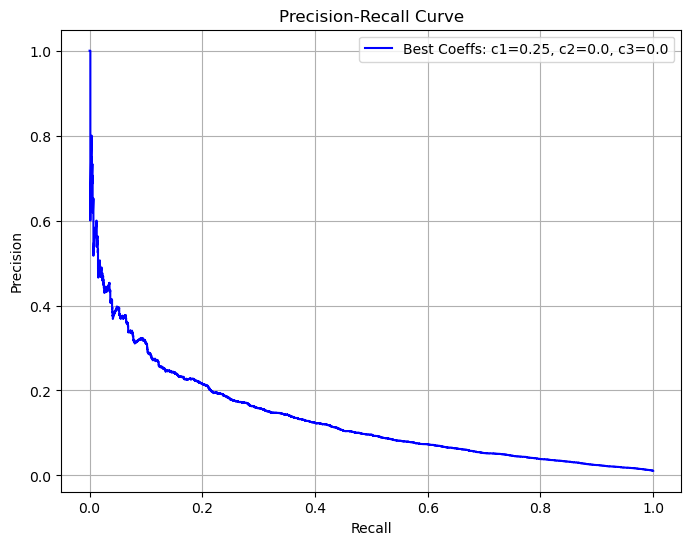

In [13]:
# Best combination of coefficients (highest F1 score)
best_result = results_df.loc[results_df['f1'].idxmax()]

# Extract best combination of coefficients
c1, c2, c3 = best_result['c1'], best_result['c2'], best_result['c3']
combined_proba_best = c1 * proba_1 + c2 * proba_2 + c3 * proba_3

# Get precision-recall curve for the best combination of coefficients
precision, recall, thresholds = precision_recall_curve(y_test, combined_proba_best)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'Best Coeffs: c1={c1}, c2={c2}, c3={c3}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## We also did the GridSearchCV on the oversampled data
Skip this if you don't have enough time - takes too long ~ 1day (especcially SVC), as a result we obtained the same pararmeters as in our undersampled search 

First we oversample data using SMOTE for each fold in StratifiedKFold

In [17]:
# Use SMOTE within each fold 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

folds_smote = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Apply SMOTE only on the training portion
    X_tr_res, y_tr_res = smote.fit_resample(X_tr, y_tr)

    folds_smote.append({
        'train': {'X': X_tr_res, 'y': y_tr_res},
        'val': {'X': X_val, 'y': y_val}
    })

In [5]:
from collections import Counter, defaultdict
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    average_precision_score
)

# For storing best params and scores
results_over = {}
best_params_summary_over = defaultdict(list)

for model_name, (model, param_grid) in models.items():
    print(f"\n====== {model_name} ======\n")
    train_recalls = []
    val_recalls = []
    val_precisions = []
    val_f1s = []
    val_pr_aucs = []
    best_params_per_fold = []

    for i, fold in enumerate(folds_over):
        X_train_fold = fold['train']['X']
        y_train_fold = fold['train']['y']
        X_val_fold = fold['val']['X']
        y_val_fold = fold['val']['y']
        
        grid = GridSearchCV(model, param_grid, cv=3, n_jobs=2, scoring="recall")
        grid.fit(X_train_fold, y_train_fold)
        best_model = grid.best_estimator_
        best_params = tuple(sorted(grid.best_params_.items()))

        best_params_per_fold.append(best_params)
        best_params_summary_over[model_name].append(best_params)

        # Predict
        y_train_pred = best_model.predict(X_train_fold)
        y_val_pred = best_model.predict(X_val_fold)
        y_val_prob = best_model.predict_proba(X_val_fold)[:, 1] if hasattr(best_model, "predict_proba") else None

        # Evaluate metrics
        train_recall = recall_score(y_train_fold, y_train_pred)
        val_recall = recall_score(y_val_fold, y_val_pred)
        val_precision = precision_score(y_val_fold, y_val_pred, zero_division=0)
        val_f1 = f1_score(y_val_fold, y_val_pred, zero_division=0)
        val_pr_auc = average_precision_score(y_val_fold, y_val_prob) if y_val_prob is not None else None

        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        val_precisions.append(val_precision)
        val_f1s.append(val_f1)
        if val_pr_auc is not None:
            val_pr_aucs.append(val_pr_auc)

        print(f"Fold {i+1}:")
        print(f"  Best Params:     {dict(best_params)}")
        print(f"  Train Recall:    {train_recall:.4f}")
        print(f"  Val Recall:      {val_recall:.4f}")
        print(f"  Val Precision:   {val_precision:.4f}")
        print(f"  Val F1 Score:    {val_f1:.4f}")
        if val_pr_auc is not None:
            print(f"  Val PR AUC:      {val_pr_auc:.4f}")
        print()

    # Most frequent best params
    most_common_params = Counter(best_params_per_fold).most_common(1)[0][0]

    results_over[model_name] = {
        "avg_train_recall": np.mean(train_recalls),
        "avg_val_recall": np.mean(val_recalls),
        "avg_precision": np.mean(val_precisions),
        "avg_f1": np.mean(val_f1s),
        "avg_pr_auc": np.mean(val_pr_aucs) if val_pr_aucs else None,
        "best_params": dict(most_common_params)
    }

# Summary
print("\n===== Summary (Selection by Recall) =====\n")
for model_name, res in results_over.items():
    print(f"{model_name}:")
    print(f"  Avg Train Recall:   {res['avg_train_recall']:.4f}")
    print(f"  Avg Val Recall:     {res['avg_val_recall']:.4f}")
    print(f"  Avg Val Precision:  {res['avg_precision']:.4f}")
    print(f"  Avg Val F1-Score:   {res['avg_f1']:.4f}")
    if res["avg_pr_auc"] is not None:
        print(f"  Avg Val PR AUC:     {res['avg_pr_auc']:.4f}")
    print(f"  Selected Best Params: {res['best_params']}\n")


====== Decision Tree ======

Fold 1:
  Best Params:     {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
  Train Recall:    0.8347
  Val Recall:      0.8325
  Val Precision:   0.7542
  Val F1 Score:    0.7915
  Val PR AUC:      0.7873

Fold 2:
  Best Params:     {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}
  Train Recall:    0.8078
  Val Recall:      0.8083
  Val Precision:   0.7521
  Val F1 Score:    0.7792
  Val PR AUC:      0.8021

Fold 3:
  Best Params:     {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
  Train Recall:    0.8697
  Val Recall:      0.8675
  Val Precision:   0.7310
  Val F1 Score:    0.7934
  Val PR AUC:      0.7991

Fold 4:
  Best Params:     {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
  Train Recall:    0.8404
  Val Recall:      0.8425
  Val Precision:   0.7491
  Val F1 Score:    0.7931
  Val PR AUC:      0.7869

Fold 5:
  Best Params:     {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
  T

Logistic Regression:     {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
KNN: { 'n_neighbors': 3}
SVC     {'C': 1, 'kernel': 'rbf'}

Decision Tree:
  Best Params:     {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
  Train Recall:    0.8404
  Val Recall:      0.8425
  Val Precision:   0.7491
  Val F1 Score:    0.7931
  Val PR AUC:      0.7869

## Oversampling on the whole training 


Using the parameters from the undersampled search we train our models on oversampled train set

SVC again takes too long 

In [14]:
models_info = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "best_params": {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "best_params": {'n_neighbors': 3}
    },
    #"SVC": {
       # "model": SVC(),
       # "best_params": {'C': 1, 'kernel': 'rbf'}
    #},
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "best_params": {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
    }
}

In [15]:
from sklearn.base import clone
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score

final_scores = {}

smote = SMOTE(random_state=42)

X_tr_res, y_tr_res = smote.fit_resample(X_train, y_train)

print("\n===== Best models using oversampling on X_test =====\n")

for model_name, info in  tqdm(models_info.items(), total=len(models_info)):
    model = info["model"]
    best_params = info["best_params"]

  
    # Train on full training data
    model.fit(X_tr_res, y_tr_res )

    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    final_recall = recall_score(y_test, y_pred)
    final_precision = precision_score(y_test, y_pred, zero_division=0)
    final_f1 = f1_score(y_test, y_pred, zero_division=0)
    final_pr_auc = average_precision_score(y_test, y_prob) if y_prob is not None else None

    final_scores[model_name] = {
        "model":model,
        "recall": final_recall,
        "precision": final_precision,
        "f1": final_f1,
        "pr_auc": final_pr_auc
    }

    print(f"{model_name}:")
    print(f"  Recall:    {final_recall:.4f}")
    print(f"  Precision: {final_precision:.4f}")
    print(f"  F1 Score:  {final_f1:.4f}")
    if final_pr_auc is not None:
        print(f"  PR AUC:    {final_pr_auc:.4f}")
    print()


===== Best models using oversampling on X_test =====



 33%|███▎      | 1/3 [00:32<01:05, 32.62s/it]

Logistic Regression:
  Recall:    0.6278
  Precision: 0.0472
  F1 Score:  0.0879
  PR AUC:    0.0941



 67%|██████▋   | 2/3 [11:01<06:23, 383.22s/it]

KNN:
  Recall:    0.3427
  Precision: 0.0478
  F1 Score:  0.0839
  PR AUC:    0.0297



100%|██████████| 3/3 [11:48<00:00, 236.26s/it]

Decision Tree:
  Recall:    0.1337
  Precision: 0.0614
  F1 Score:  0.0842
  PR AUC:    0.0178



NOw we try to find the best threshold for each model (done after the presetnation was recorded) 

And better f1 was found !!


Best threshold: 0.88 with F1 score: 0.1762

Updated scores at best threshold for Logistic Regression:
  Recall: 0.2652
  Precision: 0.1319
  F1 Score:  0.1762
  PR AUC:    0.0941


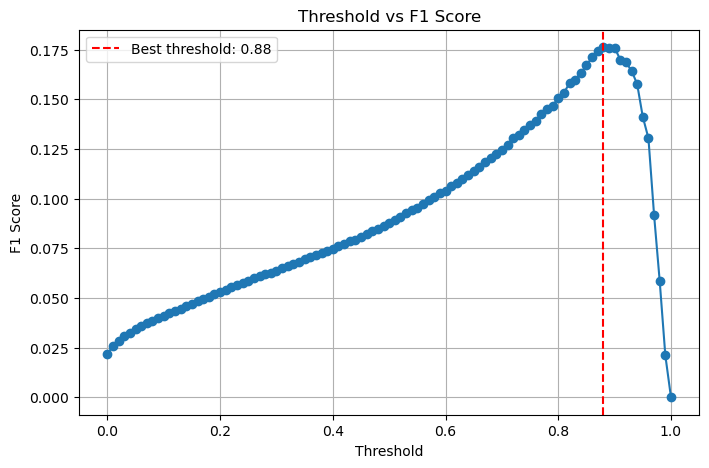

In [20]:

first_model_name = list(models_info.keys())[0]
first_model = final_scores[first_model_name]["model"]

# Predict probabilities
y_prob = first_model.predict_proba(X_test)[:, 1]

# Sweep thresholds and store F1 scores
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    f1_scores.append(f1)

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.2f} with F1 score: {best_f1:.4f}")

# Calculate precision, f1, pr_auc at the best threshold
y_pred_best = (y_prob >= best_threshold).astype(int)

final_precision = precision_score(y_test, y_pred_best, zero_division=0)
final_f1 = f1_score(y_test, y_pred_best, zero_division=0)
final_pr_auc = average_precision_score(y_test, y_prob)
final_recall = recall_score(y_test, y_pred_best)
# Save updated scores
final_scores[first_model_name].update({
    "best_threshold": best_threshold,
    "recall":final_recall,
    "precision": final_precision,
    "f1": final_f1,
    "pr_auc": final_pr_auc
})

print(f"\nUpdated scores at best threshold for {first_model_name}:")
print(f"  Recall: {final_recall:.4f}")
print(f"  Precision: {final_precision:.4f}")
print(f"  F1 Score:  {final_f1:.4f}")
print(f"  PR AUC:    {final_pr_auc:.4f}")

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold: {best_threshold:.2f}')
plt.title('Threshold vs F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

Best threshold: 0.61 with F1 score: 0.0891

Updated scores at best threshold for KNN:
  Recall: 0.2670
  Precision: 0.0535
  F1 Score:  0.0891
  PR AUC:    0.0297


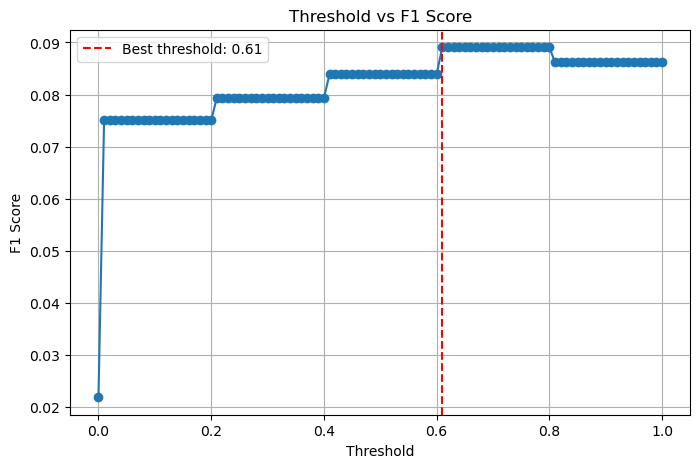

In [21]:

second_model_name = list(models_info.keys())[1]
second_model = final_scores[second_model_name]["model"]

# Predict probabilities
y_prob = second_model.predict_proba(X_test)[:, 1]

# Sweep thresholds and store F1 scores
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    f1_scores.append(f1)

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.2f} with F1 score: {best_f1:.4f}")

# Calculate precision, f1, pr_auc at the best threshold
y_pred_best = (y_prob >= best_threshold).astype(int)

final_precision = precision_score(y_test, y_pred_best, zero_division=0)
final_f1 = f1_score(y_test, y_pred_best, zero_division=0)
final_pr_auc = average_precision_score(y_test, y_prob)
final_recall = recall_score(y_test, y_pred_best)
# Save updated scores
final_scores[second_model_name].update({
    "best_threshold": best_threshold,
    "recall":final_recall,
    "precision": final_precision,
    "f1": final_f1,
    "pr_auc": final_pr_auc
})

print(f"\nUpdated scores at best threshold for {first_model_name}:")
print(f"  Recall: {final_recall:.4f}")
print(f"  Precision: {final_precision:.4f}")
print(f"  F1 Score:  {final_f1:.4f}")
print(f"  PR AUC:    {final_pr_auc:.4f}")

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold: {best_threshold:.2f}')
plt.title('Threshold vs F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

Best threshold: 0.01 with F1 score: 0.0842

Updated scores at best threshold for Decision Tree:
  Recall: 0.1337
  Precision: 0.0614
  F1 Score:  0.0842
  PR AUC:    0.0178


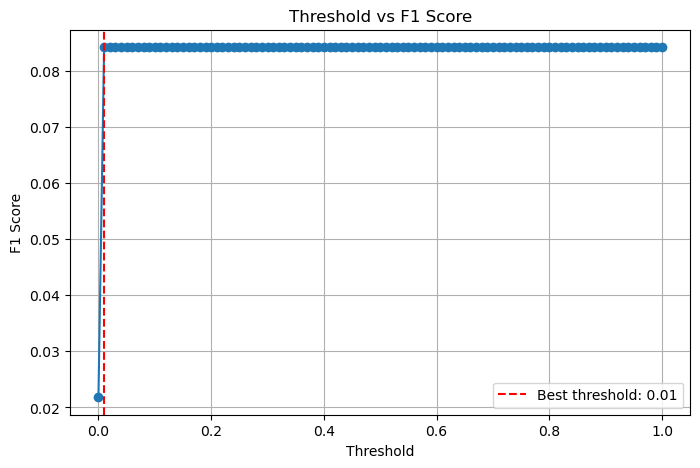

In [22]:

third_model_name = list(models_info.keys())[2]
third_model = final_scores[third_model_name]["model"]

# Predict probabilities
y_prob = third_model.predict_proba(X_test)[:, 1]

# Sweep thresholds and store F1 scores
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    f1_scores.append(f1)

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.2f} with F1 score: {best_f1:.4f}")

# Calculate precision, f1, pr_auc at the best threshold
y_pred_best = (y_prob >= best_threshold).astype(int)

final_precision = precision_score(y_test, y_pred_best, zero_division=0)
final_f1 = f1_score(y_test, y_pred_best, zero_division=0)
final_pr_auc = average_precision_score(y_test, y_prob)
final_recall = recall_score(y_test, y_pred_best)
# Save updated scores
final_scores[third_model_name].update({
    "best_threshold": best_threshold,
    "recall":final_recall,
    "precision": final_precision,
    "f1": final_f1,
    "pr_auc": final_pr_auc
})

print(f"\nUpdated scores at best threshold for {first_model_name}:")
print(f"  Recall: {final_recall:.4f}")
print(f"  Precision: {final_precision:.4f}")
print(f"  F1 Score:  {final_f1:.4f}")
print(f"  PR AUC:    {final_pr_auc:.4f}")

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold: {best_threshold:.2f}')
plt.title('Threshold vs F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [23]:
results = []

model_1_name = list(models_info.keys())[1]
model_2 = final_scores[first_model_name]["model"]

model_2_name = list(models_info.keys())[1]
model_2 = final_scores[first_model_name]["model"]

model_3_name = list(models_info.keys())[2]
model_3 = final_scores[first_model_name]["model"]

 

# Get model predictions on X_test
proba_1 = model_1.predict_proba(X_test)[:, 1]
proba_2 = model_2.predict_proba(X_test)[:, 1]
proba_3 = model_3.predict_proba(X_test)[:, 1]

# Iterate over all coefficient combinations
for c1, c2, c3 in tqdm(itertools.product(coeffs, repeat=3), total=len(coeffs)**3):  # <--- tqdm here
    if c1 == 0 and c2 == 0 and c3 == 0:
        continue  # Skip the trivial case where all coefficients are 0

    # Combine probabilities
    combined_proba = c1 * proba_1 + c2 * proba_2 + c3 * proba_3

    # Normalize to [0,1] 
    combined_proba = combined_proba / combined_proba.max()

    # Find the best threshold based on F1
    best_f1 = 0
    best_thresh = 0.5

    for t in np.arange(0, 1.01, 0.01):  # From 0.0 to 1.0 with step 0.1
        preds = (combined_proba >= t).astype(int)
        f1 = f1_score(y_test, preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    # Use best threshold to predict
    combined_pred = (combined_proba >= best_thresh).astype(int)

    # Final metrics
    final_recall = recall_score(y_test, combined_pred)
    final_precision = precision_score(y_test, combined_pred, zero_division=0)
    final_f1 = f1_score(y_test, combined_pred, zero_division=0)
    final_pr_auc = average_precision_score(y_test, combined_proba)

    # Save results
    results.append({
        "c1": c1,
        "c2": c2,
        "c3": c3,
        "threshold": best_thresh,
        "recall": final_recall,
        "precision": final_precision,
        "f1": final_f1,
        "pr_auc": final_pr_auc
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show best by F1
print(results_df.sort_values(by="f1", ascending=False))

100%|██████████| 125/125 [06:33<00:00,  3.15s/it]

       c1    c2    c3  threshold    recall  precision        f1    pr_auc
49   0.50  0.00  0.00       0.89  0.241160   0.186405  0.210277  0.134292
24   0.25  0.00  0.00       0.89  0.241160   0.186405  0.210277  0.134292
99   1.00  0.00  0.00       0.89  0.241160   0.186405  0.210277  0.134292
74   0.75  0.00  0.00       0.89  0.241160   0.186405  0.210277  0.134292
104  1.00  0.25  0.00       0.70  0.334995   0.130335  0.187659  0.106459
..    ...   ...   ...        ...       ...        ...       ...       ...
13   0.00  0.50  1.00       0.01  0.133726   0.061420  0.084177  0.017768
12   0.00  0.50  0.75       0.01  0.133726   0.061420  0.084177  0.017768
11   0.00  0.50  0.50       0.01  0.133726   0.061420  0.084177  0.017768
10   0.00  0.50  0.25       0.01  0.133726   0.061420  0.084177  0.017768
0    0.00  0.00  0.25       0.01  0.133726   0.061420  0.084177  0.017768

[124 rows x 8 columns]


So the best f1 is actually 0.241160!!